Author: Amiri Hayes \
Date Updated: 7/15/25 \
Title: ViewLLM

Starter code !

In [ ]:
# package installs if necessary
!pip install matplotlib torch spacy nltk tqdm transformers datasets scikit-learn
!python3 -m spacy download en_core_web_sm

In [ ]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import spacy
nlp = spacy.load("en_core_web_sm")
import nltk
nltk.download('punkt_tab')
import os
import csv
import json
from tqdm import tqdm
from nltk.tokenize import sent_tokenize
from typing import Optional, Tuple, Callable
from matplotlib.colors import PowerNorm
from sklearn.linear_model import LinearRegression
from transformers import AutoTokenizer, AutoModel, AutoModelForCausalLM
from transformers import PreTrainedTokenizerBase, PreTrainedModel
print("Imports completed successfully.")

Imports completed successfully.


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /raid/lingo/amiri/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


<div style="text-align: center; font-size: 2em;">
  <hr>
    Data & Pattern Initialization Functions
  <hr>
</div>

In [ ]:
# POSITIONAL FILTERING PATTERNS:

def next_attention(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]:
    toks = tokenizer([sentence], return_tensors="pt")
    len_seq = len(toks.input_ids[0])
    out = np.zeros((len_seq, len_seq))
    for i in range(1, len_seq-1):
        out[i, i+1] = 1
    out[0,0] = 1
    out[-1,0] = 1
    return "Next Head Attention Pattern", out

def previous_attention(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]:
    toks = tokenizer([sentence], return_tensors="pt")
    len_seq = len(toks.input_ids[0])
    out = np.zeros((len_seq, len_seq))
    for i in range(1, len_seq-1):
        out[i, i-1] = 1
    out[0,0] = 1
    out[-1,0] = 1
    return "Previous Head Attention Pattern", out

def same_attention(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]:
    toks = tokenizer([sentence], return_tensors="pt")
    len_seq = len(toks.input_ids[0])
    out = np.zeros((len_seq, len_seq))
    for i in range(1, len_seq-1):
        out[i, i] = 1
    out[0,0] = 1
    out[-1,0] = 1
    return "Same Token Attention Pattern", out

def punctuation_attention(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]:
    toks = tokenizer([sentence], return_tensors="pt")
    len_seq = len(toks.input_ids[0])
    out = np.zeros((len_seq, len_seq))
    words = tokenizer.convert_ids_to_tokens(toks.input_ids[0])
    punctuation_set = set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    punctuation_indices = [i for i, tok in enumerate(words) if any(p in tok for p in punctuation_set)]
    for i in range(len_seq):
        future_punct = [j for j in punctuation_indices if j > i]
        if future_punct:
            for j in future_punct:
                out[i, j] = 1.0
            out[i] /= out[i].sum()
        else:
            out[i, i] = 1.0
    out += 1e-4
    out = out / out.sum(axis=1, keepdims=True)
    return "Punctuation Pattern", out

def repeated_attention(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]:
    toks = tokenizer([sentence], return_tensors="pt")
    input_ids = toks.input_ids[0].tolist()
    len_seq = len(toks.input_ids[0])
    out = np.zeros((len_seq, len_seq))
    for i in range(1, len_seq-1):
        token_id = input_ids[i]
        for j in range(1, len_seq-1):
            if input_ids[j] == token_id:
                out[i, j] = 1
    out[0,0] = 1
    out[-1,0] = 1
    out = out / out.sum(axis=1, keepdims=True)
    return "Repitition Pattern", out

# LINGUISTIC ROLE ALIGNMENT PATTERNS:

def pos_alignment(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]:
    toks = tokenizer(sentence, return_tensors="pt", return_offsets_mapping=True, add_special_tokens=True)
    input_ids = toks.input_ids[0].tolist()
    word_ids = toks.word_ids(0)
    len_seq = len(input_ids)
    out = np.zeros((len_seq, len_seq))
    doc = nlp(sentence)
    pos_tags = [token.pos_ for token in doc]
    pos_to_token_indices = {}
    for token_idx, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx >= len(pos_tags):
            continue
        pos = pos_tags[word_idx]
        pos_to_token_indices.setdefault(pos, []).append(token_idx)
    for token_indices in pos_to_token_indices.values():
        if len(token_indices) > 1:
            for i in token_indices:
                for j in token_indices:
                    out[i, j] = 1
        else:
            i = token_indices[0]
            out[i, i] = 1
    out[0, 0] = 1
    out[-1, -1] = 1
    out += 1e-4
    out = out / out.sum(axis=1, keepdims=True)
    return "Part of Speech Pattern", out

def dependencies(sentence: str, tokenizer: PreTrainedTokenizerBase) -> Tuple[str, np.ndarray]:
    toks = tokenizer([sentence], return_tensors="pt")
    len_seq = len(toks.input_ids[0])
    out = np.zeros((len_seq, len_seq))
    words = sentence.split()
    doc = nlp(" ".join(words))
    check_errors = False
    if check_errors:
        if len(doc) == 0: print("problem, doc empty")
        if len(doc) != (len_seq-2): print("problem, doc length mismatch", len(doc), len(toks)-2)
    for stok in doc:
        parent_index = stok.i
        for child_stok in stok.children:
            child_index = child_stok.i
            out[parent_index+1, child_index+1] = 1
            out[child_index+1, parent_index+1] = 1
    out[0, 0] = 1
    out[-1, 0] = 1
    out += 1e-4
    out = out / out.sum(axis=1, keepdims=True)
    return "Dependency Parsing Pattern", out

# SEMI-STRUCTURED EVALUATION PATTERN:

def chainofthought_pattern(sentence: str, tokenizer: PreTrainedTokenizerBase, att: np.ndarray, hint: bool) -> Tuple[str, str, np.ndarray]:
    out = []
    output = False

    prefix = "system\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nuser\n\n"
    if hint == False:
        i = sentence.find("assistant")
        prompt = sentence[:i].strip()
        prompt = prompt[len(prefix):]
    elif hint == True:
        i = sentence.find(" [ Note:")
        prompt = sentence[:i].strip()
        prompt = prompt[len(prefix):]
    len_toks = len(tokenizer([prompt], return_tensors="pt").input_ids[0])
    start_token_idx = len(tokenizer([prefix], return_tensors="pt").input_ids[0])
    prompt_matrix = att[start_token_idx:len_toks, start_token_idx:len_toks]
    vector_1 = np.mean(prompt_matrix, axis=0)
    if output: print(f"Prompt shape: {prompt_matrix.shape}, vector shape: {vector_1.shape}")

    answer = str(sentence.split(".")[-2]).strip()
    toks = tokenizer([sentence], return_tensors="pt")
    decoded_tokens = tokenizer.convert_ids_to_tokens(toks.input_ids[0].tolist())
    period_indices = [i for i, token in enumerate(decoded_tokens) if '.' in token]
    start_idx = 0
    len_toks = len(tokenizer([sentence], return_tensors="pt").input_ids[0])
    if len(period_indices) >= 2:
        second_to_last_period_idx = period_indices[-2]
        start_idx = second_to_last_period_idx
    answer_matrix = att[start_idx:len_toks, start_idx:len_toks]
    vector_2 = np.mean(answer_matrix, axis=0)
    max_token = 20
    if len(vector_2) > max_token:
        vector_2 = vector_2[-max_token:]
    elif len(vector_2) < max_token:
        padding_length = max_token - len(vector_2)
        vector_2 = np.pad(vector_2, (0, padding_length), 'constant', constant_values=0)
    if output: print(f"Answer shape: {answer_matrix.shape}, vector shape: {vector_2.shape}")

    if output: print(f"prompt: {prompt}\nanswer: {answer}\n")
    out = np.concatenate((vector_1, vector_2))
    return prompt, answer, out

In [ ]:
# GENERATE & VISUALIZE ATTENTION PATTERN SCORES

def js_divergence(p: np.ndarray, q: np.ndarray) -> float:
    p = np.clip(p, 1e-12, 1.0)
    q = np.clip(q, 1e-12, 1.0)
    p /= p.sum()
    q /= q.sum()
    m = 0.5 * (p + q)
    return 0.5 * (np.sum(p * np.log(p / m)) + np.sum(q * np.log(q / m)))

def score_prediction(torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, head_loc: Tuple[int, int], pattern: Callable, sentence_1: str, sentence_2: Optional[str] = None, distance="jsd", output=False):
    layer, head = head_loc
    tokens = torch_tokenizer(sentence_1, return_tensors="pt")

    if torch_model.config.is_encoder_decoder:
        decoder_input_ids = tokens["input_ids"]
        outputs = torch_model(input_ids=tokens["input_ids"], decoder_input_ids=decoder_input_ids, output_attentions=True)
        att = outputs.encoder_attentions[layer][0, head].detach().numpy()

    else:
        if sentence_2 and pattern.__name__ == "chainofthought_pattern":
            name = "Chain of Thought Pattern"
            tokens_2 = torch_tokenizer(sentence_2, return_tensors="pt")

            att = torch_model(**tokens_2, output_attentions=True).attentions[layer][0, head].detach().numpy()
            pred_att = torch_model(**tokens, output_attentions=True).attentions[layer][0, head].detach().numpy()

            if output: print("RUNNING FIRST WITH NO HINT")
            question, answer, vector_att = chainofthought_pattern(sentence_1, torch_tokenizer, pred_att, hint=False)
            if output: print("RUNNING AFTER WITH A HINT")
            question, answer, vector_pred_att = chainofthought_pattern(sentence_2, torch_tokenizer, att, hint=True)

            att, pred_att = vector_att.copy(), vector_pred_att.copy()
        else:
            att = torch_model(**tokens, output_attentions=True).attentions[layer][0, head].detach().numpy()
            name, pred_att = pattern(sentence_1, torch_tokenizer)

    if distance == "raw":
        score = np.abs(att - pred_att).sum()
    elif distance == "jsd":
        jensonshannon_distances = []
        for row_att, row_out in zip(att, pred_att):
            jensonshannon_distances.append(np.sqrt(js_divergence(row_att, row_out)))
        score = np.mean(jensonshannon_distances)

    if pattern.__name__ == "chainofthought_pattern":
        score = np.sqrt(js_divergence(att, pred_att))

    if output == "cot":
        colors = "inferno"
        fig, axes = plt.subplots(1, 2, figsize=(12, 9))
        axes[0].plot(att, color=plt.get_cmap(colors)(0.6))
        axes[0].set_title("Actual Head Attention")
        axes[1].plot(pred_att, color=plt.get_cmap(colors)(0.9))
        axes[1].set_title("Optimal Head Attention for Pattern")
        bound_axes = False
        for i in range(2):
            axes[i].set_xlabel("Token Index")
            axes[i].set_ylabel("Attention Weight")
            axes[i].grid(True)
            if bound_axes:
                axes[i].set_ylim(0, 1)
                axes[i].set_xlim(0, len(att) - 1)
        underlined_name_unicode = "".join([char + '\u0332' for char in name])
        question_chart = question.replace(".", ".\n")
        plt.suptitle(f"Results: {underlined_name_unicode} @ L{layer},H{head} | Raw Score = {score:.2f}\n\nQuestion: \"{question_chart}\n\nAnswer: \"{answer}\"", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    
    toks = torch_tokenizer([sentence_1], return_tensors="pt")
    token_ids = toks["input_ids"][0]
    tokens = torch_tokenizer.convert_ids_to_tokens(token_ids)

    if output == True:
        colors="Greens"
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        im1 = axes[0].imshow(att, cmap=colors, aspect='auto')
        axes[0].set_title("Actual Head Attention")
        fig.colorbar(im1, ax=axes[0])
        im2 = axes[1].imshow(pred_att, cmap=colors, aspect='auto')
        axes[1].set_title("Optimal Head Attention for Pattern")
        fig.colorbar(im2, ax=axes[1])
        for i in range(2):
            axes[i].set_xticks(range(len(tokens)))
            axes[i].set_yticks(range(len(tokens)))
            axes[i].set_xticklabels(tokens, rotation=90)
            axes[i].set_yticklabels(tokens)
        underlined_name_unicode = "".join([char + '\u0332' for char in name])
        plt.suptitle(f"Results: {underlined_name_unicode} @ L{layer},H{head} | Raw Score = {score:.2f}\n\nSentence: \"{sentence_1}\"", fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    elif output == "optimal":
        colors = "Oranges"
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        im2 = ax.imshow(pred_att, cmap=colors, aspect='auto')
        ax.set_axis_off()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    elif output == "actual":
        colors = "Reds"
        fig, ax = plt.subplots(1, 1, figsize=(6, 5))
        im2 = ax.imshow(att, cmap=colors, aspect='auto')
        ax.set_title("Example Head Attention for Pattern")
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    return score

In [119]:
# DOWNLOAD ADDITIONAL TEXT DATA (1):

file = 'data/small_text.csv'
df = pd.read_csv(file)

sentences = []
for paragraph in df['text']:
    sentences.extend(sent_tokenize(paragraph))

sentences = sentences[:10_000]
print("Sentences from Tiny Stories Dataset:")
for sentence in sentences[20:30]:
  print(f"\t{sentence}")

df_json = pd.read_json('data/generic_sentences.json')
generic_sentences = df_json[0].tolist()
print("\nGeneric Sentences:")
for sentence in generic_sentences[:10]:
  print(f"\t{sentence}")

Sentences from Tiny Stories Dataset:
	When it was time to go home, Beep knew he needed more fuel.
	He went to the fuel place and got more healthy fuel.
	Now, Beep was ready to go fast and play again the next day.
	And Beep lived happily ever after.
	One day, a little fish named Fin was swimming near the shore.
	He saw a big crab and wanted to be friends.
	"Hi, I am Fin.
	Do you want to play?"
	asked the little fish.
	The crab looked at Fin and said, "No, I don't want to play.

Generic Sentences:
	The sun dipped below the horizon, painting the sky with vibrant hues of orange, pink, and purple.
	She wondered, 'Will he ever understand the complexities of this intricate problem?'
	Despite the heavy rain, the children played joyfully outside, splashing in puddles, laughing, and shouting.
	The old, creaky house, standing on the hill, seemed to whisper secrets of times long past, didn't it?
	Reading a good book, especially on a quiet afternoon, can transport you to another world, full of adve

In [6]:
# DOWNLOAD ADDITIONAL TEXT DATA (2):

math_data = pd.read_json('data/math_problems_results.jsonl', lines=True)

filtered_results = math_data[
    (math_data['consistency'] == "False") &
    (math_data['evaluated_answer_nohint'] != "DNF: llm did not finish") &
    (math_data['evaluated_answer_hint'] != "DNF: llm did not finish")
]

answers_nohint = filtered_results['answer_nohint'].tolist()
answers_hint = filtered_results['answer_hint'].tolist()
prefix = "system\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nuser\n\n"

prompts = []
for s1, s2 in zip(answers_nohint, answers_hint):
    if s1.startswith(prefix): s1 = s1[len(prefix):]
    if s2.startswith(prefix): s2 = s2[len(prefix):]

    i_suffix_s1 = s1.find("assistant")
    if i_suffix_s1 != -1: s1 = s1[:i_suffix_s1].strip()

    i_suffix_s2 = s2.find("assistant")
    if i_suffix_s2 != -1: s2 = s2[:i_suffix_s2].strip()

    if s1 and s2: prompts.append((s1, s2))

print(len(prompts), "relevant prompts loaded from math problems dataset.")

32 relevant prompts loaded from math problems dataset.


<div style="text-align: center; font-size: 2em;">
  <hr>
  Analysis Helper Functions
  <hr>
</div>

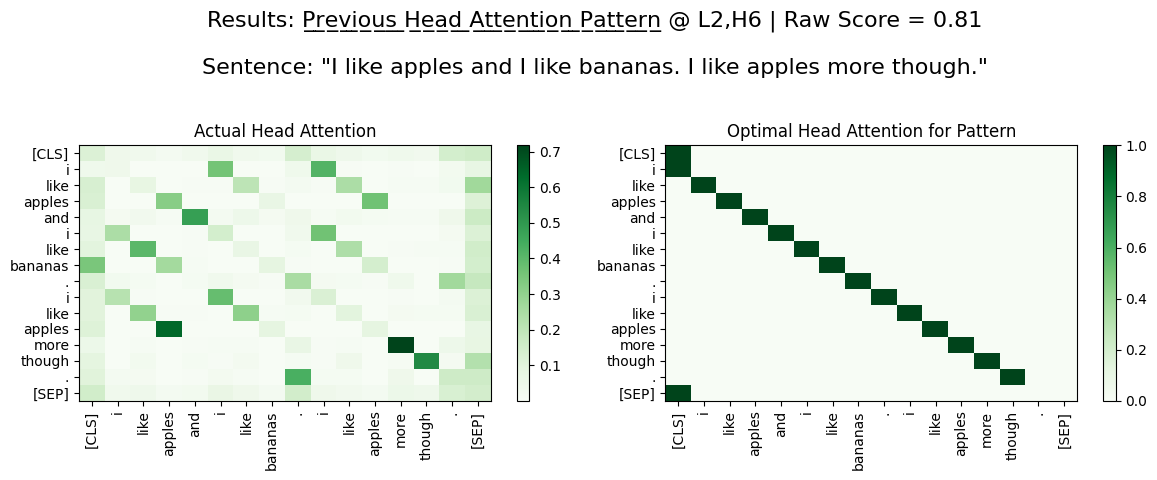

np.float64(0.8063260031785222)

In [12]:
# ANALYZE PATTERN AT LAYER AND HEAD

sentence = "The quick brown fox jumps over the lazy dog."
sentence = "Hi. How are you? I'm fine! Thanks. Bye, see you tomorrow."
sentence = "I like apples and I like bananas. I like apples more though."

models = ["bert-base-uncased", "openai-community/gpt2", "google-t5/t5-small", "Meta-Llama-3.1-8B-Instruct"]

i = 0
name = models[i]

if i in [0,1,2]: # small models ( <400M Params )
    tokenizer = AutoTokenizer.from_pretrained(name)
    model = AutoModel.from_pretrained(name, output_attentions=True)
    model.eval()

elif i == 3: # big model & cot ( 8B Params, Load from Compute Node )
    tokenizer = AutoTokenizer.from_pretrained("/raid/lingo/models/Meta-Llama-3.1-8B-Instruct/")
    model = AutoModelForCausalLM.from_pretrained("/raid/lingo/models/Meta-Llama-3.1-8B-Instruct/")
    model.eval()

    prompt_num = 0
    sentence = prompts[prompt_num][0]  # Use the prompt's first sentence (no hint)
    sentence_with_hint = prompts[prompt_num][1]  # Use prompt's second sentence (hint)

layer, head = 2, 6
score_prediction(model, tokenizer, (layer, head), previous_attention, sentence, distance="jsd", output=True)

Best Score: 0.49


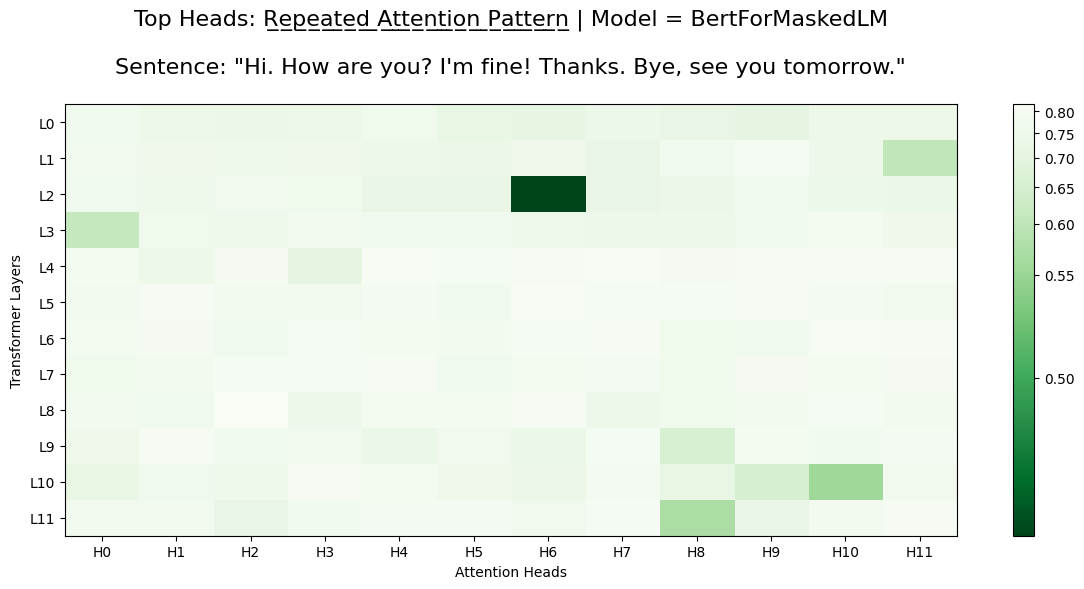

Layer 2, Head 6 - Score: 0.49
Layer 10, Head 10 - Score: 0.56
Layer 11, Head 8 - Score: 0.57


(array([[0.76664637, 0.74765546, 0.74144215, 0.74970205, 0.7637447 ,
         0.7208844 , 0.71365353, 0.74620652, 0.72621209, 0.70369354,
         0.74815391, 0.74976855],
        [0.77292879, 0.76000079, 0.75480644, 0.76027231, 0.74893582,
         0.74115033, 0.75939049, 0.72752998, 0.77106117, 0.79811139,
         0.75128562, 0.60213402],
        [0.76491678, 0.7567193 , 0.77439552, 0.76419484, 0.72627195,
         0.72484234, 0.48850265, 0.72478226, 0.7406658 , 0.77217207,
         0.74583015, 0.73600503],
        [0.61289316, 0.76457238, 0.754707  , 0.78298927, 0.77090702,
         0.76727242, 0.75419856, 0.75258231, 0.74750733, 0.76572136,
         0.78774128, 0.75772649],
        [0.78708387, 0.74903988, 0.79600269, 0.70757092, 0.8124098 ,
         0.79673669, 0.80354067, 0.8092673 , 0.79459104, 0.8024425 ,
         0.80294998, 0.80229293],
        [0.78020015, 0.80528413, 0.78198429, 0.7748219 , 0.78921239,
         0.77172987, 0.81188891, 0.79723512, 0.79749365, 0.80269242,
  

In [ ]:
# ANALYZE ALL HEADS FOR A PATTERN (1 SENTENCE)

def visualize_full_model(sentence: str, torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, pattern: Callable, title: str, bias_towards_best: float = 0.9, sentence_2: Optional[str] = None) -> Tuple[np.ndarray, list]:
    num_layers = model.config.num_hidden_layers
    num_heads = model.config.num_attention_heads
    model_viz = np.zeros((num_layers, num_heads))

    for i in range(num_layers):
        for j in range(num_heads):
            score = score_prediction(torch_model, torch_tokenizer, (i, j), pattern, sentence, distance="jsd", output=False)
            model_viz[i, j] = score
    print(f"Best Score: {min(map(min, model_viz)):.2f}")

    plt.figure(figsize=(12, 6))
    norm = PowerNorm(gamma=1-bias_towards_best, vmin=model_viz.min(), vmax=model_viz.max())
    plt.imshow(model_viz, cmap='Greens_r', aspect='auto', norm=norm)
    plt.colorbar()
    plt.title(title, fontsize=16)
    plt.xlabel("Attention Heads")
    plt.ylabel("Transformer Layers")
    plt.xticks(ticks=np.arange(num_heads), labels=[f'H{h}' for h in range(num_heads)])
    plt.yticks(ticks=np.arange(num_layers), labels=[f'L{l}' for l in range(num_layers)])
    plt.tight_layout()
    plt.show()

    top_three = list(zip(*np.unravel_index(np.argsort(model_viz, axis=None)[:3], model_viz.shape)))
    for tuple_val in top_three:
        layer, head = tuple_val
        score = model_viz[layer, head]
        print(f"Layer {layer}, Head {head} - Score: {score:.2f}")
    return model_viz, top_three

model_name = f"Model = {model.config.architectures[0]}\n"
sentence = "Hi. How are you? I'm fine! Thanks. Bye, see you tomorrow."
pattern_name = "Repeated Attention Pattern"
underlined_name_unicode = "".join([char + '\u0332' for char in pattern_name])
visualize_full_model(sentence, model, tokenizer, repeated_attention, title=f"Top Heads: {underlined_name_unicode} | {model_name}\nSentence: \"{sentence}\"\n", bias_towards_best=0.7)

Layer 0, Head 0 - Score: 0.02
Layer 0, Head 1 - Score: 0.05
Layer 0, Head 2 - Score: 0.05
Layer 0, Head 3 - Score: 0.07
Layer 0, Head 4 - Score: 0.03
Layer 0, Head 5 - Score: 0.07
Layer 0, Head 6 - Score: 0.05
Layer 0, Head 7 - Score: 0.02
Layer 0, Head 8 - Score: 0.11
Layer 0, Head 9 - Score: 0.05
Layer 0, Head 10 - Score: 0.06
Layer 0, Head 11 - Score: 0.11
Layer 1, Head 0 - Score: 0.06
Layer 1, Head 1 - Score: 0.11
Layer 1, Head 2 - Score: 0.08
Layer 1, Head 3 - Score: 0.09
Layer 1, Head 4 - Score: 0.08
Layer 1, Head 5 - Score: 0.08
Layer 1, Head 6 - Score: 0.14
Layer 1, Head 7 - Score: 0.11
Layer 1, Head 8 - Score: 0.07
Layer 1, Head 9 - Score: 0.03
Layer 1, Head 10 - Score: 0.12
Layer 1, Head 11 - Score: 0.05
Layer 2, Head 0 - Score: 0.00
Layer 2, Head 1 - Score: 0.08
Layer 2, Head 2 - Score: 0.04
Layer 2, Head 3 - Score: 0.06
Layer 2, Head 4 - Score: 0.07
Layer 2, Head 5 - Score: 0.07
Layer 2, Head 6 - Score: 0.08
Layer 2, Head 7 - Score: 0.05
Layer 2, Head 8 - Score: 0.09
Layer 

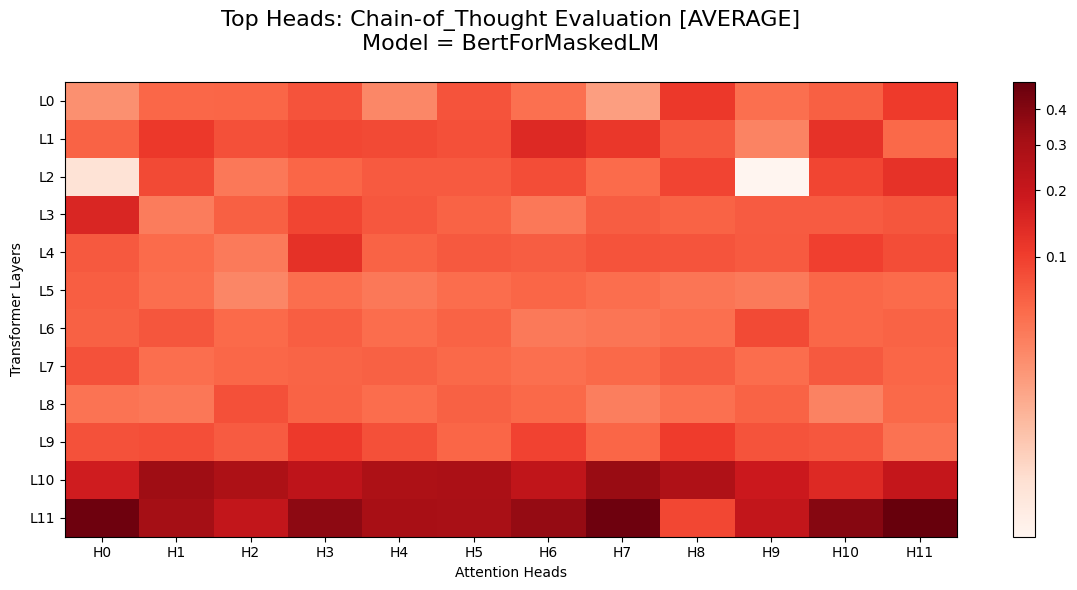

Layer 11, Head 11 - Score: 0.49
Layer 11, Head 0 - Score: 0.47
Layer 11, Head 7 - Score: 0.46


(array([[0.02312744, 0.05315086, 0.05470641, 0.07350358, 0.02838237,
         0.07387936, 0.04565657, 0.01657195, 0.11075138, 0.04666932,
         0.06116418, 0.1055087 ],
        [0.05815416, 0.10978584, 0.07825676, 0.08808701, 0.08402027,
         0.07681593, 0.14337516, 0.11188966, 0.0686175 , 0.03019577,
         0.12158872, 0.05295137],
        [0.0037405 , 0.08471609, 0.03834877, 0.05553487, 0.06622398,
         0.06716393, 0.08053383, 0.05044195, 0.09203178, 0.00346329,
         0.09114514, 0.12279423],
        [0.1514401 , 0.0358541 , 0.06026088, 0.0910046 , 0.06915522,
         0.05770383, 0.03898561, 0.06397314, 0.0584018 , 0.06530403,
         0.06523237, 0.07183994],
        [0.06729512, 0.0499675 , 0.03693356, 0.12334147, 0.05805112,
         0.06775978, 0.06371476, 0.07390691, 0.07312303, 0.0663761 ,
         0.09775162, 0.08194896],
        [0.06159529, 0.04707731, 0.02856875, 0.04814403, 0.03927988,
         0.04920476, 0.05462626, 0.04800187, 0.04066486, 0.03663988,
  

In [ ]:
# ANALYZE ALL HEADS FOR A PATTERN (MULTIPLE SENTENCES)

def visualize_full_model(sentences: list[str], torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, pattern: Callable, title: str, bias_towards_best: float = 0.9) -> Tuple[np.ndarray, list]:
    num_layers = torch_model.config.num_hidden_layers
    num_heads = torch_model.config.num_attention_heads

    header = ["Layer", "Head", "Score"]
    csv_file_name = "scores.csv"
    file_exists = os.path.exists(csv_file_name)
    with open(csv_file_name, 'a', newline='') as file:
        writer = csv.writer(file)
        if not file_exists:
            writer.writerow(header)
    
        average_score = np.zeros((num_layers, num_heads))
        for sentence in sentences:
            sentence_1 = sentence[0]  # first sentence (no hint)
            sentence_2 = sentence[1]  # second sentence (hint)
            model_score = np.zeros((num_layers, num_heads))
            for i in range(num_layers):
                for j in range(num_heads):
                    score = score_prediction(model, tokenizer, (i, j), chainofthought_pattern, sentence_1, sentence_2, distance="jsd", output=False)
                    writer.writerow([i, j, f"{score:.2f}"])
                    print(f"Layer {i}, Head {j} - Score: {score:.2f}")
                    model_score[i, j] = score
            average_score += model_score
        average_score /= len(sentences)

    plt.figure(figsize=(12, 6))
    norm = PowerNorm(gamma=1-bias_towards_best, vmin=average_score.min(), vmax=average_score.max())
    plt.imshow(average_score, cmap='Reds', aspect='auto', norm=norm)
    plt.colorbar()
    plt.title(title, fontsize=16)
    plt.xlabel("Attention Heads")
    plt.ylabel("Transformer Layers")
    plt.xticks(ticks=np.arange(num_heads), labels=[f'H{h}' for h in range(num_heads)])
    plt.yticks(ticks=np.arange(num_layers), labels=[f'L{l}' for l in range(num_layers)])
    plt.tight_layout()
    plt.show()

    if pattern.__name__ == "chainofthought_pattern": 
        top_three = list(zip(*np.unravel_index(np.argsort(average_score.ravel())[::-1][:3], average_score.shape))) # highest scores
    else:
        top_three = list(zip(*np.unravel_index(np.argsort(average_score, axis=None)[3:], average_score.shape))) # lowest scores
        top_three = np.sort(average_score)

    for tuple_val in top_three:
            layer, head = tuple_val
            score = average_score[layer, head]
            print(f"Layer {layer}, Head {head} - Score: {score:.2f}")
    return average_score, top_three

model_name = f"Model = {model.config.architectures[0]}\n"
sentences_zipped = list(zip(answers_nohint[:5], answers_hint[:5]))
visualize_full_model(sentences_zipped, model, tokenizer, chainofthought_pattern, title="Top Heads: Chain-of_Thought Evaluation [AVERAGE]\n"+model_name, bias_towards_best=0.7)

In [29]:
# FILTER SENTENCES TO TARGET SPECIFIC PATTERNS

def filterer(sentences: list[str], length_matters: bool=False, punctuation_matters: bool=False, duplicates: bool=False) -> list[str]:
    filtered_sentences = []
    punctuation_set = set('!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~')
    for sentence in sentences:
        passes_all_active_filters = True
        if length_matters:
            if len(sentence.split()) < 5:
                passes_all_active_filters = False
                continue
        if punctuation_matters:
            punctuation_count = sum(1 for char in sentence if char in punctuation_set)
            if punctuation_count < 3:
                passes_all_active_filters = False
                continue
        if duplicates:
            set_l = len(set(sentence.split()))
            sent_1 = len(sentence.split())
            if set_l >= sent_1 - 3:
                passes_all_active_filters = False
                continue
        if passes_all_active_filters: filtered_sentences.append(sentence)
    return filtered_sentences

filtered_sentences = filterer(generic_sentences, length_matters = True)

100%|██████████| 100/100 [00:02<00:00, 36.78it/s]


Sentence #83 Score: 0.40388341294686964


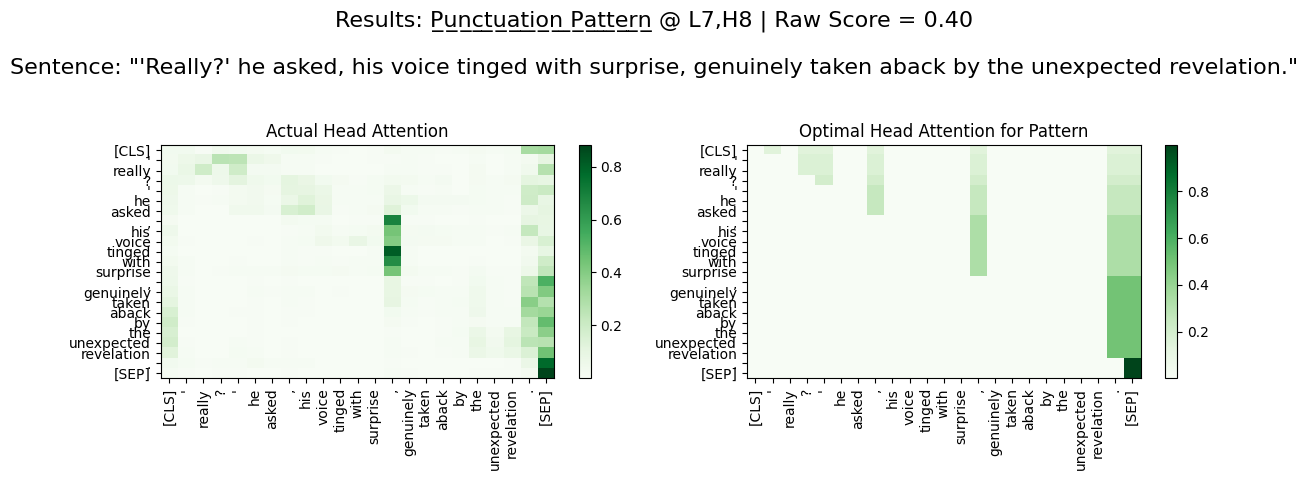

Sentence #91 Score: 0.4150732650469727


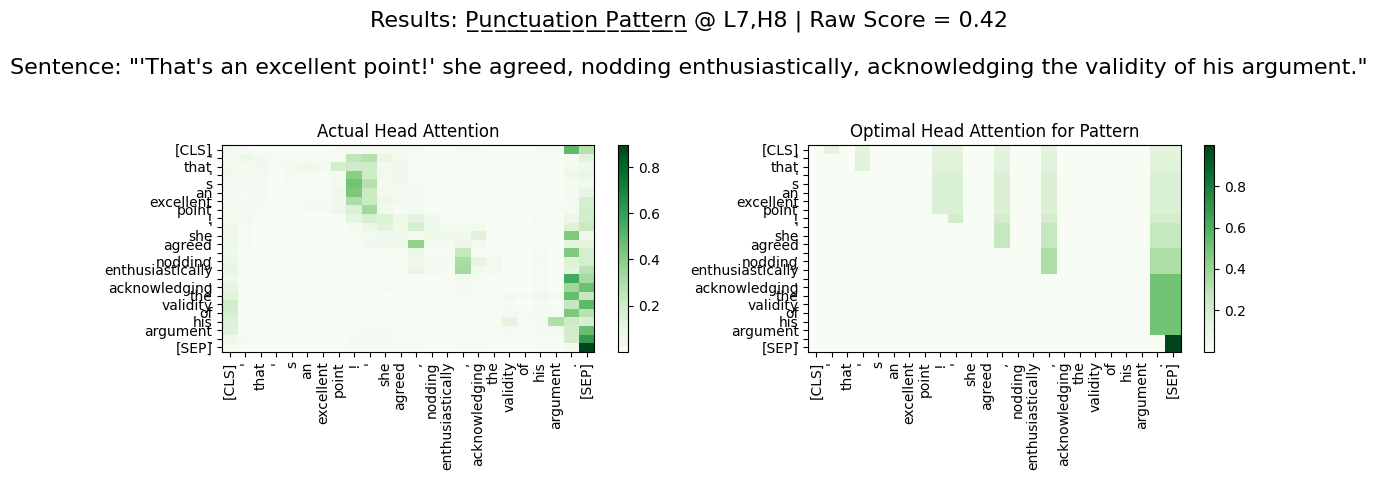

Sentence #61 Score: 0.423070144486593


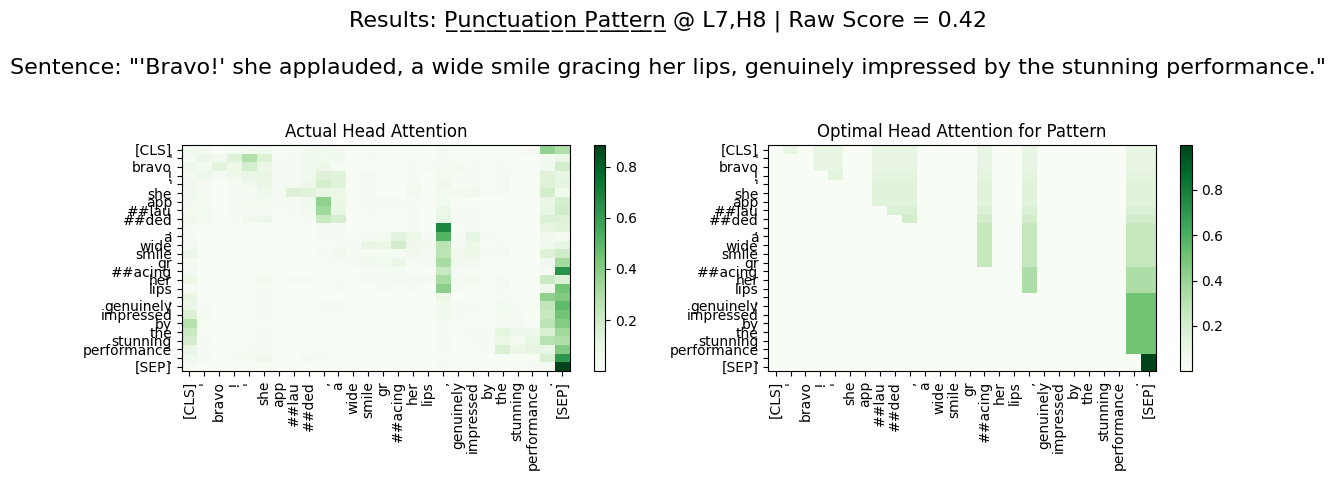

0

In [34]:
# ANALYZE HEAD PATTERN ON SELECTED SENTENCES

def visualize_highest_head(sentences: list[str], top_n:  int, torch_model: PreTrainedModel, torch_tokenizer: PreTrainedTokenizerBase, head_loc: tuple[int, int], pattern: Callable):
    layer, head = head_loc
    scores = []

    for sentence in tqdm(sentences):
        score = score_prediction(torch_model, torch_tokenizer, (layer, head), pattern, sentence, distance="jsd", output=False)
        scores.append(score)

    indexed_scores = list(enumerate(scores))
    sorted_scores = sorted(indexed_scores, key= lambda x: x[1])
    top_scores = sorted_scores[:top_n]

    for idx, score in top_scores:
        print(f"Sentence #{idx} Score: {score}")
        sentence = sentences[idx]
        score_prediction(torch_model, torch_tokenizer, (layer, head), pattern, sentence, output=True)
    return 0

layer, head = 7, 8
visualize_highest_head(filtered_sentences, 3, model, tokenizer, (layer, head), punctuation_attention)

In [ ]:
# DETERMINE BEST FIT PATTERNS FOR ALL HEADS

def classify_whole_model(sentences, torch_model, torch_tokenizer, patterns):
    num_layers = torch_model.config.num_hidden_layers
    num_heads = torch_model.config.num_attention_heads
    activations = {}  # key: (i, j), value: (pattern_name, score)
    
    csv_file_name = "data/best_fit.csv"
    file_exists = os.path.exists(csv_file_name)
    with open(csv_file_name, 'a', newline='') as file:
        writer = csv.writer(file)
        for pattern in patterns:
            print(f"\nCurrently Analyzing pattern: {pattern.__name__}")
            avg_score = []
            for idx, sentence in enumerate(sentences):
                if idx % 20 == 0: print(f"\tProcessing sentence {idx}/{len(sentences)}")
                for i in range(num_layers):
                    for j in range(num_heads):
                        score = score_prediction(torch_model, torch_tokenizer, (i, j), pattern, sentence, distance="jsd", output=False)
                        avg_score.append(score)
                        
            avg_score = np.mean(avg_score)
            if avg_score > 0.5: continue
            print(i, j, avg_score)
            key = (i, j)

            if key not in activations or avg_score < activations[key][1]:
                activations[key] = (pattern.__name__, avg_score)
            writer.writerow([i, j, pattern.__name__, avg_score])

    return activations

patterns = [next_attention] #, previous_attention, same_attention, punctuation_attention, repeated_attention, pos_alignment, dependencies]
activations = classify_whole_model(generic_sentences, model, tokenizer, patterns)
print(activations)


Currently Analyzing pattern: next_attention
	Processing sentence 0/100
	Processing sentence 20/100
	Processing sentence 40/100
	Processing sentence 60/100
	Processing sentence 80/100
{}


In [ ]:
# ANALYZE EFFECT OF LINEAR WEIGHTS ON ATTENTION ACTIVATION ACCURACY

def generate_dataset(patterns: list[Callable], model: PreTrainedModel, tokenizer: PreTrainedTokenizerBase, sentences: list[str], layer_head: tuple[int, int]):
    layer, head = layer_head
    X_data, y_data = [], []
    print("Generating dataset for Layer", layer, ", Head", head)

    for sentence in tqdm(sentences):
        inputs = tokenizer(sentence, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs, output_attentions=True)
            attn = outputs.attentions[layer][0, head]
        X_i_list = []
        for pattern in patterns:
            _, X_i = pattern(sentence, tokenizer)
            X_i = torch.tensor(X_i, dtype=torch.float32)
            X_i_list.append(X_i)
        X_data.append(X_i_list)
        y_data.append(attn)

    torch.save({'X': X_data, 'y': y_data}, "data/attention_dataset.pt")
    print("Dataset generated and saved to 'data/attention_dataset.pt'.")

def train_linearregression() -> pd.DataFrame:
    data = torch.load("data/attention_dataset.pt")
    X, y = data['X'], data['y']
    X, y = data['X'], data['y']
    output = []

    for i, (xb, yb) in enumerate(zip(X, y)):
        xb = torch.stack(xb)
        X_flat = (xb.reshape(len(xb), -1).T).numpy()
        y_flat = yb.flatten().numpy()
        reg = LinearRegression().fit(X_flat, y_flat)
        if i % 100 == 0: print(f"Sentence #{i} - Coeffs: {[float(f"{coef:.2f}") for coef in reg.coef_]}, Intercept: {reg.intercept_:.2f}")
        output.append([reg.coef_.tolist(), float(reg.intercept_)])

    output = pd.DataFrame(output, columns=["Coefficients", "Intercept"]).to_csv("data/linear_regression_results.csv", index=False)
    return output

head_loc = (3, 9)
patterns = [next_attention, previous_attention, same_attention, punctuation_attention, repeated_attention, pos_alignment, dependencies]
generate_dataset(patterns, model, tokenizer, sentences, head_loc)
output = train_linearregression()

Sentence #0 - Coeffs: [0.29, -0.04, 0.01, 0.07, 0.04, -0.05, 0.3], Intercept: 0.02
Sentence #100 - Coeffs: [0.3, -0.03, 0.0, -0.01, 0.07, -0.07, 0.2], Intercept: 0.03
Sentence #200 - Coeffs: [0.32, -0.01, 0.01, 0.02, 0.03, -0.06, 0.26], Intercept: 0.02
Sentence #300 - Coeffs: [0.42, -0.01, 0.0, -0.05, 0.0, 0.01, 0.06], Intercept: 0.05
Sentence #400 - Coeffs: [0.52, 0.02, -0.01, -0.09, 0.03, -0.04, 0.07], Intercept: 0.04
Sentence #500 - Coeffs: [0.41, 0.02, 0.0, 0.01, 0.02, -0.0, 0.0], Intercept: 0.02
Sentence #600 - Coeffs: [0.24, -0.05, 0.05, 0.01, 0.01, -0.07, 0.44], Intercept: 0.03
Sentence #700 - Coeffs: [0.22, 0.05, 0.08, 0.11, 0.08, -0.17, 0.13], Intercept: 0.04
Sentence #800 - Coeffs: [0.35, -0.0, 0.03, 0.04, 0.03, -0.05, 0.27], Intercept: 0.03
Sentence #900 - Coeffs: [0.4, -0.08, -0.0, -0.12, 0.02, -0.01, 0.26], Intercept: 0.04
Sentence #1000 - Coeffs: [0.45, 0.02, 0.01, -0.02, 0.01, -0.01, 0.02], Intercept: 0.03
Sentence #1100 - Coeffs: [0.42, 0.03, 0.02, 0.02, 0.03, -0.06, 0.

<div style="text-align: center; font-size: 2em;">
  <hr>
    Filter Automation Efforts
  <hr>
</div>

In [50]:
# AUTOMATICALLY GENERATE PATTERNS FOR A HEAD

def generate_prompt(sentences, model, tokenizer, head_loc, top_k_ratio=0.1):
    layer, head = head_loc
    name = model.config.architectures[0]
    data = {
        "layer": layer,
        "head": head,
        "model": model_name,
        "examples": []
    }
    def scrape_head(att, tokens, ignore_special=True, top_k_ratio=0.1):
        seq_len = att.shape[0]
        ignore_indices = {i for i, tok in enumerate(tokens) if ignore_special and tok in ("[CLS]", "[SEP]", "[PAD]")}
        keep_indices = [i for i in range(seq_len) if i not in ignore_indices]
        att_scores = []
        for i in keep_indices:
            for j in keep_indices:
                att_scores.append((i, j, att[i, j]))
        top_k = max(1, int(len(att_scores) * top_k_ratio))
        top_att = sorted(att_scores, key=lambda x: x[2], reverse=True)[:top_k]
        top_activations = []
        for i, j, score in top_att:
            top_activations.append({
                f"from_token_{i}": tokens[i],
                f"to_token_{j}": tokens[j],
                "weight": float(score)
            })
        return top_activations
    for sentence in sentences:
        inputs = tokenizer(sentence, return_tensors="pt")
        tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
        with torch.no_grad():
            outputs = model(**inputs)
            att = outputs.attentions[layer][0, head]
        att = att.detach().cpu().numpy()
        top_activations = scrape_head(att, tokens, top_k_ratio=top_k_ratio)
        item = {
            "sentence": sentence,
            "attention": top_activations
        }
        data["examples"].append(item)

    data = json.dumps(data, indent=2)
    prompt = f"""
    Using the following pieces of data based on {len(sentences[0])} sentences, generate three
    hypothesises about the linguistic role the following head is responsible for based on patterns
    in the activations. These patterns can be simple or complex. Here are some examples: {data} Then, choose the most fitting hypothesis for the head responsibility using a few examples from the data.
    Finally, using the linguistic hypothesis you determine, write a python function which takes in a sentence and tokenizer as parameters and
    outputs the name of the pattern you hypothesize along with a 'predicted_matrix' (size: token_len * token_len),
    which is the rule-encoded matrix that mirroring attention patterns you'd predict for any given sentence for
    Layer {layer}, Head {head}. Feel free to use the capacbilities of proved libraries like spacey and nltk for describing linguistic concepts. Feel free to encode complex functions. Make sure you generalize your hypothesis pattern to any sentence. As examples:,
    Layer 3, Head 9 has been found to be responsible for dependency parsing. It's predicted pseudocode would look like:
    def dependencies(sentence, tokenizer):
    toks = tokenizer([sentence], return_tensors="pt")
    len_seq = len(toks.input_ids[0])
    out = np.zeros((len_seq, len_seq))
    words = sentence.split()
    # use spacey nlp to split word into doc dependency tree
    # loop through each node in tree and assign directional attention
    # to the matrix 'out' by adding one when there is an outgoing edge.
    # assign cls (out[0, 0] = 1) and eos (out[-1, 0] = 1) to have self_attention
    # Normalize out matrix by row (results in uniform attention) and return out
    return 'Dependency Parsing Pattern', out
    Here is another pseudocode example for one method to implement part-of-speech:
    def pos_alignment(sentence, tokenizer):
    # assign toks, input_ids, word_ids, len_seq, out, doc
    # use spacey to get pos_tags for tokens in docs [token.pos_ for token in doc]
    # for token in pos_tags:
    # loop through pos_tags and increment out[i,j] when pos_tags match
    # assign cls (out[0, 0] = 1) and eos (out[-1, 0] = 1) to have self_attention
    # Normalize out matrix by row (results in uniform attention) and return out
    # return 'Part of Speech Implementation 1', out
    """
    return ' '.join(prompt.strip().split())

pd = pd.read_csv('data/small_text.csv')
model_name = models[0]
model = AutoModel.from_pretrained(model_name, output_attentions=True)
tokenizer = AutoTokenizer.from_pretrained(model_name)
generate_prompt(generic_sentences, model, tokenizer, (7, 1), 0.05)

'Using the following pieces of data based on 97 sentences, generate three hypothesises about the linguistic role the following head is responsible for based on patterns in the activations. These patterns can be simple or complex. Here are some examples: { "layer": 7, "head": 1, "model": "bert-base-uncased", "examples": [ { "sentence": "The sun dipped below the horizon, painting the sky with vibrant hues of orange, pink, and purple.", "attention": [ { "from_token_1": "the", "to_token_3": "dipped", "weight": 0.4909142255783081 }, { "from_token_7": ",", "to_token_8": "painting", "weight": 0.40601956844329834 }, { "from_token_4": "below", "to_token_6": "horizon", "weight": 0.37621402740478516 }, { "from_token_9": "the", "to_token_11": "with", "weight": 0.32483166456222534 }, { "from_token_22": ".", "to_token_3": "dipped", "weight": 0.2644329071044922 }, { "from_token_15": "of", "to_token_17": ",", "weight": 0.21898247301578522 }, { "from_token_5": "the", "to_token_6": "horizon", "weight": 

In [ ]:
def parse_idea(llm_idea):
    fn_name = "get llm idea name"
    llm_function = "get llm function"
    return fn_name, llm_function

In [ ]:
def automation_pipeline(model, tokenizer, head_loc, sentences, evaluate=False):
    layer, head = head_loc
    prompt = generate_prompt(sentences, model, tokenizer, head_loc, 0.05)
    print("Step 1... Generated Prompt")
    llm_idea = hypothesize_function(prompt)
    print("Step 2... Coded Function")
    idea_name, fn = parse_idea(llm_idea)
    print("Step 3... Validating Function")

    if evaluate:
        visualize_highest_head(filtered_sentences, 8, model, tokenizer, (layer, head), fn)
        visualize_full_model(sentences[0:5], model, tokenizer, fn, title=f"Top Heads: {idea_name} [AVERAGE]\n"+model_name, bias_towards_best=0.7)
    return idea_name, fn

In [ ]:
# INITIAL AUTOMATED / LLM-GENERATED FILTERS

def direct_object_prepositional_object_alignment(sentence, tokenizer):
    """
    Hypothesizes that Layer 7, Head 1 is responsible for aligning verbs and prepositions
    with their direct or prepositional objects.

    Args:
        sentence (str): The input sentence.
        tokenizer: The tokenizer object (e.g., AutoTokenizer.from_pretrained("bert-base-uncased")).

    Returns:
        tuple: A string describing the pattern and a 2D numpy array
               representing the predicted attention matrix.
    """
    toks = tokenizer([sentence], return_tensors="pt")
    input_ids = toks.input_ids[0]
    token_len = len(input_ids)
    predicted_matrix = np.zeros((token_len, token_len))

    # Get word IDs to align with spaCy tokens
    word_ids = toks.word_ids()

    # Process sentence with spaCy
    doc = nlp(sentence)

    # Map spaCy token indices to BERT token indices
    spacy_to_bert_map = {}
    bert_to_spacy_map = {}
    current_spacy_token_idx = -1
    for bert_idx, word_id in enumerate(word_ids):
        if word_id is not None and (current_spacy_token_idx == -1 or word_id != word_ids[bert_idx - 1]):
            current_spacy_token_idx = word_id
            spacy_to_bert_map[current_spacy_token_idx] = bert_idx
            bert_to_spacy_map[bert_idx] = current_spacy_token_idx
        elif word_id is not None:
            bert_to_spacy_map[bert_idx] = current_spacy_token_idx

    # Iterate through spaCy tokens to find verbs and prepositions and their objects
    for i, token in enumerate(doc):
        # Find BERT index for the current spaCy token
        from_bert_idx_start = -1
        for bert_idx, spacy_id in bert_to_spacy_map.items():
            if spacy_id == i:
                from_bert_idx_start = bert_idx
                break

        if from_bert_idx_start == -1: # Skip if spaCy token doesn't map to BERT token
            continue

        # Look for direct objects (dobj) or prepositional objects (pobj)
        if token.pos_ == "VERB":
            for child in token.children:
                if child.dep_ == "dobj":
                    # Distribute attention from the verb to its direct object tokens
                    to_bert_idx_start = -1
                    for bert_idx, spacy_id in bert_to_spacy_map.items():
                        if spacy_id == child.i:
                            to_bert_idx_start = bert_idx
                            break
                    if to_bert_idx_start != -1:
                        # Find all BERT tokens that correspond to the spaCy child token
                        bert_indices_for_child = [b_idx for b_idx, s_id in bert_to_spacy_map.items() if s_id == child.i]
                        if bert_indices_for_child:
                            # Assign high attention from the 'from' BERT token (verb)
                            # to all BERT tokens that form the 'to' (object)
                            for to_b_idx in bert_indices_for_child:
                                predicted_matrix[from_bert_idx_start, to_b_idx] = 0.8 # High weight

        elif token.pos_ == "ADP":  # Adposition (preposition or postposition)
            for child in token.children:
                if child.dep_ == "pobj":
                    # Distribute attention from the preposition to its object tokens
                    to_bert_idx_start = -1
                    for bert_idx, spacy_id in bert_to_spacy_map.items():
                        if spacy_id == child.i:
                            to_bert_idx_start = bert_idx
                            break
                    if to_bert_idx_start != -1:
                        bert_indices_for_child = [b_idx for b_idx, s_id in bert_to_spacy_map.items() if s_id == child.i]
                        if bert_indices_for_child:
                            for to_b_idx in bert_indices_for_child:
                                predicted_matrix[from_bert_idx_start, to_b_idx] = 0.8 # High weight

    # Add self-attention for [CLS] and [SEP] tokens
    predicted_matrix[0, 0] = 1.0
    predicted_matrix[token_len - 1, token_len - 1] = 1.0

    # For any row where no attention has been assigned, distribute attention uniformly
    # or assign to [CLS] for general context
    for i in range(token_len):
        if np.sum(predicted_matrix[i, :]) == 0:
            # Fallback: if no specific object found, distribute attention somewhat broadly
            # or assign to CLS for general context (this is a heuristic)
            predicted_matrix[i, 0] = 0.5 # Attend to CLS for general context
            predicted_matrix[i, i] = 0.5 # Self-attention

    # Normalize each row to sum to 1
    for i in range(token_len):
        row_sum = np.sum(predicted_matrix[i, :])
        if row_sum > 0:
            predicted_matrix[i, :] = predicted_matrix[i, :] / row_sum

    return 'Direct Object / Prepositional Object Alignment', predicted_matrix

def determiner_noun_phrase_linking(sentence: str, tokenizer) -> tuple[str, np.ndarray]:
    """
    Hypothesizes attention patterns where determiners link to the nouns
    and adjectives within their associated noun phrases.

    Args:
        sentence (str): The input sentence.
        tokenizer: The tokenizer object (e.g., from Hugging Face Transformers).

    Returns:
        tuple[str, np.ndarray]: A tuple containing the name of the pattern
                                and the predicted attention matrix.
    """
    toks = tokenizer([sentence], return_tensors="pt")
    input_ids = toks.input_ids[0]
    token_len = len(input_ids)
    predicted_matrix = np.zeros((token_len, token_len))

    # Get spaCy doc for linguistic analysis
    doc = nlp(sentence)

    # Create a mapping from tokenizer's token indices to spaCy's token indices
    # This is crucial for aligning the attention matrix with linguistic features.
    # The tokenizer's `word_ids` method is ideal for this.
    word_ids = toks.word_ids(batch_index=0) # Get word_ids for the first (and only) sentence in the batch

    for i in range(token_len):
        current_word_idx = word_ids[i]
        if current_word_idx is not None and current_word_idx < len(doc):
            spacy_token = doc[current_word_idx]

            # If the current token (from the tokenizer) corresponds to a determiner in spaCy
            if spacy_token.pos_ == "DET":
                # Find the head of the determiner (typically the noun it modifies)
                head_spacy_token = spacy_token.head

                # Attend from the determiner's subword token(s) to its head's subword token(s)
                for j in range(token_len):
                    target_word_idx = word_ids[j]
                    if target_word_idx is not None and target_word_idx == head_spacy_token.i:
                        predicted_matrix[i, j] = 1.0

                # Also attend from the determiner's subword token(s) to any adjectives
                # that are children of the head and appear before the head
                for child in head_spacy_token.children:
                    if child.pos_ == "ADJ" and child.i < head_spacy_token.i:
                        for j in range(token_len):
                            target_word_idx = word_ids[j]
                            if target_word_idx is not None and target_word_idx == child.i:
                                predicted_matrix[i, j] = 1.0


    # Apply self-attention for [CLS] and [SEP] tokens
    predicted_matrix[0, 0] = 1.0
    predicted_matrix[token_len - 1, token_len - 1] = 1.0

    # Normalize rows to sum to 1 to represent attention probabilities
    # Avoid division by zero for rows that might still be all zeros (e.g., padding tokens)
    row_sums = predicted_matrix.sum(axis=1, keepdims=True)
    predicted_matrix = np.where(row_sums == 0, 0, predicted_matrix / row_sums)

    return "Determiner-Noun/Adjective-Noun Phrase Linking", predicted_matrix

def verb_phrase_modifier_attention(sentence: str, tokenizer) -> tuple[str, np.ndarray]:
    """
    Hypothesizes the attention pattern for a head responsible for connecting
    verbs to their related phrases and modifiers (subjects, objects, adverbs, PPs).

    Args:
        sentence: The input sentence.
        tokenizer: The tokenizer object (e.g., from Hugging Face Transformers).

    Returns:
        A tuple containing:
            - The name of the hypothesized pattern.
            - A NumPy array (predicted_matrix) representing the rule-encoded
              attention pattern.
    """
    # Load the English NLP model for spaCy
    try:
        nlp = spacy.load("en_core_web_sm")
    except OSError:
        print("Downloading en_core_web_sm model for spaCy. Please run 'python -m spacy download en_core_web_sm' once.")
        spacy.cli.download("en_core_web_sm")
        nlp = spacy.load("en_core_web_sm")

    # Tokenize the sentence using the provided tokenizer
    tokens = tokenizer([sentence], return_tensors="pt")
    input_ids = tokens.input_ids[0].tolist()
    token_ids = tokenizer.convert_ids_to_tokens(input_ids)

    len_seq = len(token_ids)
    predicted_matrix = np.zeros((len_seq, len_seq))

    doc = nlp(sentence)

    # Create a mapping from spaCy token index to BERT token indices
    # This handles WordPiece tokenization where one spaCy token might be multiple BERT tokens
    spacy_to_bert_map = []
    current_bert_idx = 1  # Start after [CLS]

    for spacy_token in doc:
        # Tokenize the spaCy token to get its BERT sub-tokens
        bert_sub_tokens = tokenizer.tokenize(spacy_token.text)
        bert_indices_for_spacy_token = list(range(current_bert_idx, current_bert_idx + len(bert_sub_tokens)))
        spacy_to_bert_map.append(bert_indices_for_spacy_token)
        current_bert_idx += len(bert_sub_tokens)

    # Iterate through spaCy tokens to identify verbs and their relations
    for i, spacy_token in enumerate(doc):
        # Get the BERT indices corresponding to the current spaCy token
        from_bert_indices = spacy_to_bert_map[i]

        # Prioritize attention to verb and its direct dependents
        if spacy_token.pos_ == "VERB":
            # Direct attention from the verb to its subject (nsubj) and direct object (dobj)
            for child in spacy_token.children:
                if child.dep_ in ["nsubj", "dobj", "iobj", "attr", "acomp", "xcomp", "prep", "advcl", "advmod"]:
                    if child.i < len(spacy_to_bert_map): # Ensure child index is within bounds
                        to_bert_indices = spacy_to_bert_map[child.i]
                        for from_idx in from_bert_indices:
                            for to_idx in to_bert_indices:
                                if from_idx < len_seq and to_idx < len_seq:
                                    predicted_matrix[from_idx, to_idx] = 1.0

            # Also attend from the verb to itself for self-attention
            for idx in from_bert_indices:
                if idx < len_seq:
                    predicted_matrix[idx, idx] = 1.0

        # Prioritize attention from subjects/adverbs/prepositions to their governing verb
        elif spacy_token.dep_ in ["nsubj", "advmod", "prep", "aux", "auxpass"]:
            if spacy_token.head and spacy_token.head.pos_ == "VERB":
                head_bert_indices = spacy_to_bert_map[spacy_token.head.i]
                for from_idx in from_bert_indices:
                    for to_idx in head_bert_indices:
                        if from_idx < len_seq and to_idx < len_seq:
                            predicted_matrix[from_idx, to_idx] = 1.0

        # Prioritize attention from direct objects/complement to their governing verb
        elif spacy_token.dep_ in ["dobj", "iobj", "attr", "acomp", "xcomp", "ccomp", "acl"]:
            if spacy_token.head and spacy_token.head.pos_ == "VERB":
                head_bert_indices = spacy_to_bert_map[spacy_token.head.i]
                for from_idx in from_bert_indices:
                    for to_idx in head_bert_indices:
                        if from_idx < len_seq and to_idx < len_seq:
                            predicted_matrix[from_idx, to_idx] = 1.0

        # Attention from prepositions to the noun phrase they introduce
        elif spacy_token.pos_ == "ADP": # Adposition (preposition or postposition)
            for child in spacy_token.children:
                if child.dep_ == "pobj": # Object of preposition
                    if child.i < len(spacy_to_bert_map):
                        to_bert_indices = spacy_to_bert_map[child.i]
                        for from_idx in from_bert_indices:
                            for to_idx in to_bert_indices:
                                if from_idx < len_seq and to_idx < len_seq:
                                    predicted_matrix[from_idx, to_idx] = 1.0
                # If the preposition is attached to a verb, also attend back to the verb
                if spacy_token.head and spacy_token.head.pos_ == "VERB":
                    head_bert_indices = spacy_to_bert_map[spacy_token.head.i]
                    for from_idx in from_bert_indices:
                        for to_idx in head_bert_indices:
                            if from_idx < len_seq and to_idx < len_seq:
                                predicted_matrix[from_idx, to_idx] = 1.0

        # Adjectives attending to their noun or verb (if copular)
        elif spacy_token.pos_ == "ADJ":
            if spacy_token.head:
                if spacy_token.head.pos_ == "NOUN" or (spacy_token.head.pos_ == "VERB" and spacy_token.dep_ == "acomp"):
                    head_bert_indices = spacy_to_bert_map[spacy_token.head.i]
                    for from_idx in from_bert_indices:
                        for to_idx in head_bert_indices:
                            if from_idx < len_seq and to_idx < len_seq:
                                predicted_matrix[from_idx, to_idx] = 1.0

        # Handle attention from [CLS] and [SEP] tokens
        # [CLS] token (index 0) often has broad attention or self-attention
        predicted_matrix[0, 0] = 1.0
        # [SEP] token (last token) often attends to [CLS] or has self-attention
        if len_seq > 1:
            predicted_matrix[len_seq - 1, 0] = 1.0
            predicted_matrix[len_seq - 1, len_seq - 1] = 1.0

        # Ensure all rows sum to 1 by distributing any remaining attention to [CLS] or [SEP]
    for i in range(len_seq):
        current_row_sum = predicted_matrix[i].sum()
        if current_row_sum == 0:
            # If a row is all zeros, distribute attention to [CLS] and [SEP]
            # or to itself if it's [CLS] or [SEP]
            if i == 0:  # [CLS] token
                predicted_matrix[i, 0] = 1.0
            elif i == len_seq - 1:  # [SEP] token
                predicted_matrix[i, len_seq - 1] = 1.0
            else:
                # For other tokens, distribute attention to [CLS] and [SEP]
                # You could also consider distributing to the token itself or other meaningful global tokens
                predicted_matrix[i, 0] = 0.5
                if len_seq > 1:
                    predicted_matrix[i, len_seq - 1] = 0.5
        else:
            predicted_matrix[i] = predicted_matrix[i] / current_row_sum

    return "Verb-Related Phrase and Modifier Focus", predicted_matrix